In [2]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from code.utils.utils import get_int_from_
from code.utils.settings import DefaultPath

Ora ho i risultati di JOSIE-top3 in formato csv 'set_id,s1,o1,s2,o2,s3,o3', voglio andare a ottenere un qualcosa del tipo 'l_id,r_id,o' e raggruppare le coppie così ottenute per l'overlap, con intervali tipo [1,10), [10,50),[50,100)... e poi su questi intervalli vedo quali coppie hanno il corrispetivo nei risultati di SLOTH.

Su queste coppie poi si possono fare meglio delle considerazioni sulla similarità data dagli embedding anche, perché è rimosso (?) il bias della Jaccard similarity.

In [3]:
n = 10000

In [12]:
id_table_file = DefaultPath.josie_stuff_path.base + f'josie-test-{n}/id_table.csv'
id_conversion_table = pl.read_csv(id_table_file)
sloth_results = pl.scan_csv(DefaultPath.data_path.wikitables + 'threshold-r5-c2-a50/sloth-results-r5-c2-a50.csv')

josie_ids, sloth_ids = list(id_conversion_table.to_dict(as_series=False).values())
id_conversion_table = None

In [13]:
converter = {j: s for j, s in zip(josie_ids, sloth_ids)}

In [35]:
josie_results = pl.scan_csv(DefaultPath.josie_stuff_path.base + f'josie-test-{n}/result_k_5.csv')
pairs = pl.LazyFrame(schema=['r_id', 's_id', 'overlap'])

In [33]:
def split_numbers(s):
    nums = get_int_from_(s)
    return nums[::2], nums[1::2]    # set IDs, overlaps

In [36]:
josie_results = josie_results \
    .select(['query_id', 'results']) \
        .with_columns(
            pl.col('results') \
                .map_elements(split_numbers, pl.List(pl.List(pl.Int64)))
            ) \
                .with_columns(pl.col('results').list.to_struct()) \
                    .unnest('results') \
                        .explode('field_0', 'field_1') \
                            .collect()               

josie_results = josie_results \
    .drop_nulls() \
        .map_rows(lambda t: (converter[t[0]], converter[t[1]], t[2]))
josie_results.columns = ['r_id', 's_id', 'overlap']
josie_results

r_id,s_id,overlap
str,str,i64
"""24216428-1""","""9996355-1""",20
"""24216428-1""","""24216428-2""",19
"""24216428-1""","""30875393-1""",11
"""24216428-1""","""2453209-1""",11
"""24216428-1""","""27304653-1""",11
…,…,…
"""22194841-2""","""16531889-1""",3
"""22194841-2""","""22179933-1""",3
"""22194841-2""","""16531873-1""",3


In [42]:
final_results = josie_results.lazy().join(sloth_results, on=['r_id', 's_id']).collect().sort('overlap')
final_results

r_id,s_id,overlap,jsim,o_a,a%
str,str,i64,f64,i64,f64
"""23797865-10""","""23797865-2""",1,0.740741,64,0.888889
"""23797865-1""","""23797865-10""",1,0.740741,64,0.888889
"""23797865-1""","""23797865-6""",2,0.724138,64,0.888889
"""23797865-1""","""23797865-7""",2,0.724138,64,0.888889
"""23797865-12""","""23797865-7""",2,0.807692,64,0.888889
…,…,…,…,…,…
"""16517223-1""","""16559174-1""",765,0.81258,1190,0.449735
"""16559174-1""","""16682980-1""",795,0.842894,1465,0.549925
"""16519520-1""","""16559174-1""",803,0.867637,1345,0.51063


In [41]:
steps = [range(1, 5), range(5, 10), range(10, 20), range(20, 50), range(50, 100), range(100, 200), range(200, 500), range(500, 1000)]

In [43]:
def mapper(t):
    for s in steps:
        if t in s:
            return f'[{s.start},{s.stop})' if s.stop != 1000 else f'[{s.start},inf)'
        
col = final_results.columns
final_results = final_results.map_rows(
    lambda t: (t[0], t[1], mapper(t[2]), t[3], t[4], t[5])
)
final_results.columns = col
final_results

r_id,s_id,overlap,jsim,o_a,a%
str,str,str,f64,i64,f64
"""23797865-10""","""23797865-2""","""[1,5)""",0.740741,64,0.888889
"""23797865-1""","""23797865-10""","""[1,5)""",0.740741,64,0.888889
"""23797865-1""","""23797865-6""","""[1,5)""",0.724138,64,0.888889
"""23797865-1""","""23797865-7""","""[1,5)""",0.724138,64,0.888889
"""23797865-12""","""23797865-7""","""[1,5)""",0.807692,64,0.888889
…,…,…,…,…,…
"""16517223-1""","""16559174-1""","""[500,inf)""",0.81258,1190,0.449735
"""16559174-1""","""16682980-1""","""[500,inf)""",0.842894,1465,0.549925
"""16519520-1""","""16559174-1""","""[500,inf)""",0.867637,1345,0.51063


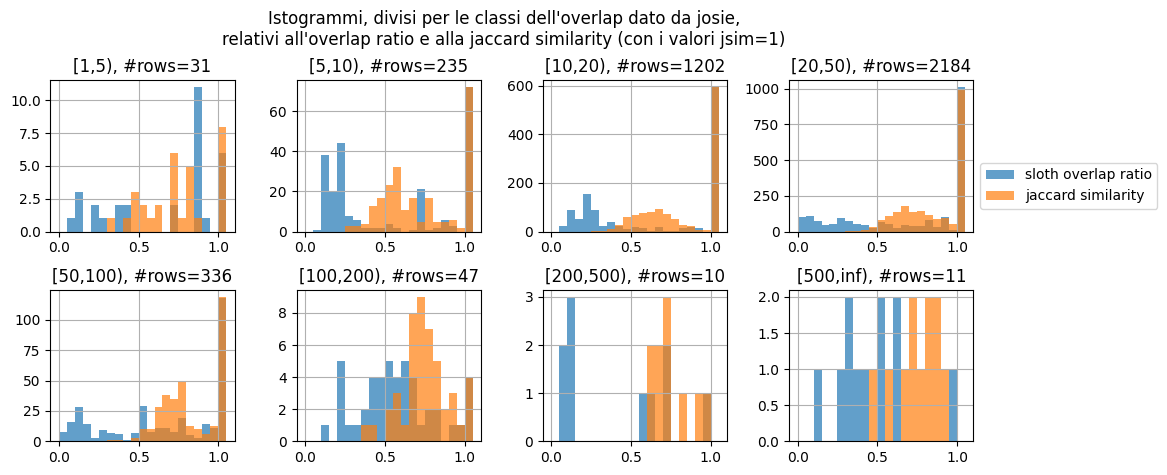

In [78]:
ncol = len(steps) // 2
fig, axes = plt.subplots(2, ncol, figsize=(10, 5))
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.8)
fig.suptitle('Istogrammi, divisi per le classi dell\'overlap dato da josie,\nrelativi all\'overlap ratio e alla jaccard similarity (con i valori jsim=1)', y=0.94)
for i in range(2):
    for j in range(ncol):
        r = steps[i * ncol + j]
        ax = axes[i][j]
        tag = f'[{r.start},{r.stop})' if r.stop != 1000 else f'[{r.start},inf)'
        rows = final_results.filter(pl.col('overlap') == tag)
        title = f'{tag}, #rows={rows.shape[0]}'

        ax.set_title(title)
        ax.hist(rows['a%'],     bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='sloth overlap ratio')
        ax.hist(rows['jsim'],   bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='jaccard similarity')
        ax.grid(True)
axes[0][3].legend(bbox_to_anchor=(1, 0.5))

plt.show()

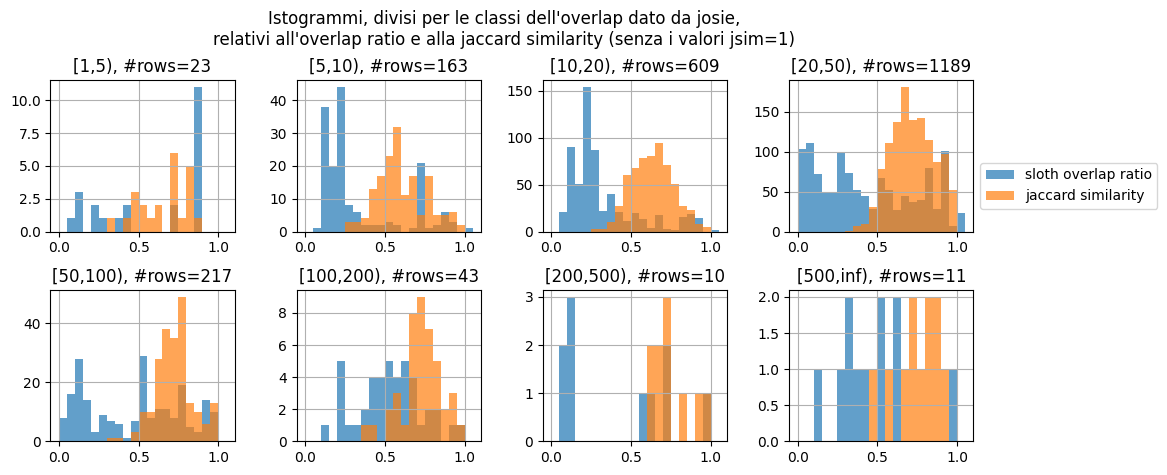

In [77]:
ncol = len(steps) // 2
fig, axes = plt.subplots(2, ncol, figsize=(10, 5))
fig.tight_layout(h_pad=3)
fig.subplots_adjust(top=0.8)
fig.suptitle('Istogrammi, divisi per le classi dell\'overlap dato da josie,\nrelativi all\'overlap ratio e alla jaccard similarity (senza i valori jsim=1)', y=0.94)
for i in range(2):
    for j in range(ncol):
        r = steps[i * ncol + j]
        ax = axes[i][j]
        tag = f'[{r.start},{r.stop})' if r.stop != 1000 else f'[{r.start},inf)'
        rows = final_results.filter((pl.col('overlap') == tag) & (pl.col('jsim') != 1))        
        title = f'{tag}, #rows={rows.shape[0]}'

        ax.set_title(title)
        ax.hist(rows['a%'],     bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='sloth overlap ratio')
        ax.hist(rows['jsim'],   bins=np.arange(0, 1.1, 0.05), align='mid', alpha=0.7, label='jaccard similarity')
        ax.grid(True)
axes[0][3].legend(bbox_to_anchor=(1, 0.5))

plt.show()

In [60]:
tag = f'[5,10)'
rows = final_results.filter((pl.col('overlap') == tag) & (pl.col('jsim') != 1))

In [75]:
rows.sort(by=['a%', 'jsim'], descending=True)[40:50]

r_id,s_id,overlap,jsim,o_a,a%
str,str,str,f64,i64,f64
"""1056366-1""","""1056425-1""","""[5,10)""",0.962963,88,0.488889
"""35035287-2""","""35037587-3""","""[5,10)""",0.486486,32,0.484848
"""18992950-1""","""18992950-2""","""[5,10)""",0.666667,40,0.444444
"""33527826-1""","""33528344-1""","""[5,10)""",0.490909,20,0.4
"""24230225-1""","""9167545-1""","""[5,10)""",0.509434,50,0.378788
"""7011838-2""","""7015936-2""","""[5,10)""",0.904762,30,0.357143
"""2965316-1""","""2965480-1""","""[5,10)""",0.482759,21,0.333333
"""1056314-1""","""1056366-1""","""[5,10)""",0.854545,48,0.32
"""1056314-1""","""1056425-1""","""[5,10)""",0.854545,48,0.32
